# How Debuggers Work

In this chapter, we show how _interactive debuggers_ work – tools that allow you to observe the program state during an execution.  Thanks to the power of Python, we can even build our own debugger in a few lines of code.

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging.ipynb).
* Knowing a bit of _Python_ is helpful for understanding the code examples in the book.

In [175]:
import bookutils

## Debugger Features

_Interactive Debuggers_ (or short *debuggers*) are tools that allow you to observe program executions. A debugger typically offers the following features:

* _Run_ the program
* Define a condition under which the execution should _stop_ and hand over control to the debugger. Conditions include
    * a particular location is reached
    * a particular variable takes a particular value
    * or some other condition of choice.
* When the program stops, you can _observe_ the current state, including
    * the current location
    * variables and their values
    * the current function and its callers
* When the program stops, you can _step_ through program execution, having it stop at the next instruction again.
* Finally, you can also _resume_ execution to the next stop.

These commands typically are used in a loop. First, you identify the location(s) you want to inspect, and tell the debugger to stop execution once one of these location(s) is reached. Then you have the debugger run the program. When it stops at the given location, you inspect the state (and check whether things are as expected). You can then step through the program or define new stop conditions and resume execution.

This functionality can come as a _command-line interface_, typing commands at a prompt, or as a _graphical user interface_, selecting commands from the screen. Debuggers can come as standalone tools, or be integrated into a programming environment of choice.

## Debugger Interaction

The key idea of an _interactive_ debugger is to set up the tracing function such that it actually _asks_ what to do next, prompting you to enter a _command_. For the sake of simplicity, we collect such a command from a command line, using the Python `input()` function. The following code prompts you to enter a command:

In [176]:
INPUTS = []

In [177]:
from bookutils import HTML

In [178]:
def my_input(prompt):
    given_input = None
    try:
        global INPUTS
        given_input = INPUTS[0]
        INPUTS = INPUTS[1:]
    except:
        pass
    
    if given_input:
        display(HTML(f"<pre>{prompt}{given_input}</pre>"))
        return given_input
    
    return input(prompt)

In [179]:
from Intro_Debugging import remove_html_markup

In [180]:
import inspect

In [181]:
from Tracer import Tracer

In [182]:
class Debugger(Tracer):
    def __init__(self):
        self.stepping = True
        self.breakpoints = set()
        self.interact = True
        
        self.frame = None
        self.event = None
        self.arg = None

        super().__init__()

    def step_command(self, arg=""):
        """Execute up to the next line"""
        self.stepping = True
        self.interact = False

    def continue_command(self, arg=""):
        """Resume execution"""
        self.stepping = False
        self.interact = False

    def list_command(self, arg=""):
        """Show current function. If function is given, show its source code."""
        if arg:
            try:
                obj = eval(arg)
                source_lines, line_number = inspect.getsourcelines(obj)
            except Exception as err:
                self.log(f"{err.__class__.__name__}: {err}")
                return
            current_line = -1
        else:
            source_lines, line_number = inspect.getsourcelines(self.frame.f_code)
            current_line = self.frame.f_lineno
    
        for line in source_lines:
            spacer = ' '
            if line_number == current_line:
                spacer = '>'
            elif line_number in self.breakpoints:
                spacer = '#'
            self.log(f'{line_number:4}{spacer} {line}', end='')
            line_number += 1
    
    def print_command(self, arg=""):
        """Print an expression. If no expression is given, print all variables"""
        vars = self.frame.f_locals
        
        if not arg:
            self.log("\n".join([f"{var} = {repr(vars[var])}" for var in vars]))
        else:
            try:
                self.log(f"{arg} = {repr(eval(arg, globals(), vars))}")
            except Exception as err:
                self.log(f"{err.__class__.__name__}: {err}")

    def break_command(self, arg=""):
        """Set a breakoint in given line. If no line is given, print all breakpoints"""
        if arg:
            self.breakpoints.add(int(arg))
        self.log("Breakpoints:", self.breakpoints)

    def delete_command(self, arg=""):
        """Delete a breakoint in given line. If no line is given, clear all breakpoints"""
        if arg:
            try:
                self.breakpoints.remove(int(arg))
            except KeyError:
                self.log(f"No such breakpoint: {arg}")
        else:
            self.breakpoints = []
        self.log("Breakpoints:", self.breakpoints)
        
    def quit_command(self, arg=""):
        """Finish execution"""
        self.breakpoints = []
        self.stepping = False
        self.interact = False
        
    def help_command(self, command=""):
        """Give help on given command. If no command is given, give help on all"""
        
        if command:
            possible_cmds = [possible_cmd for possible_cmd in self.commands() if possible_cmd.startswith(command)]

            if len(possible_cmds) == 0:
                self.log(f"Unknown command {repr(command)}. Possible commands are:")
                possible_cmds = self.commands()
            elif len(possible_cmds) > 1:
                self.log(f"Ambiguous command {repr(command)}. Possible expansions are:")
                
        else:
            possible_cmds = self.commands()

        for cmd in possible_cmds:
            method = self.command_method(cmd)
            self.log(f"{cmd:10} -- {method.__doc__}")

    def command_method(self, command):
        if command.startswith('#'):
            return None

        possible_cmds = [possible_cmd for possible_cmd in self.commands() if possible_cmd.startswith(command)]
        if len(possible_cmds) != 1:
            self.help_command(command)
            return None
        
        cmd = possible_cmds[0]
        return getattr(self, cmd + '_command')
        
    def execute(self, command):
        sep = command.find(' ')
        if sep > 0:
            cmd = command[:sep].strip()
            arg = command[sep + 1:].strip()
        else:
            cmd = command.strip()
            arg = ""

        method = self.command_method(cmd)
        if method:
            method(arg)

    def commands(self):
        cmds = [method.replace('_command', '') for method in dir(self.__class__) if method.endswith('_command')]
        cmds.sort()
        return cmds
    
    def traceit(self, frame, event, arg):
        self.frame = frame
        self.event = event
        self.arg = arg

        if self.stepping or frame.f_lineno in self.breakpoints:
            self.print_debugger_status(frame, event, arg)

            self.interact = True
            while self.interact:
                command = my_input("(debugger) ")
                self.execute(command)

        return self.traceit

In [183]:
debugger = Debugger()

In [184]:
debugger.commands()

['break', 'continue', 'delete', 'help', 'list', 'print', 'quit', 'step']

In [185]:
debugger.execute('h')

break      -- Set a breakoint in given line. If no line is given, print all breakpoints
continue   -- Resume execution
delete     -- Delete a breakoint in given line. If no line is given, clear all breakpoints
help       -- Give help on given command. If no command is given, give help on all
list       -- Show current function. If function is given, show its source code.
print      -- Print an expression. If no expression is given, print all variables
quit       -- Finish execution
step       -- Execute up to the next line


In [186]:
debugger.execute('b 25')

Breakpoints: {25}


In [187]:
debugger.execute('h q')

quit       -- Finish execution


In [188]:
debugger.execute('co')

In [215]:
with Debugger():
    ret = remove_html_markup("<b>abc</b>")
ret

Calling remove_html_markup(s = '<b>abc</b>')


(debugger)  s


223     tag   = False


(debugger)  p s


s = '<b>abc</b>'


(debugger)  p


s = '<b>abc</b>'


(debugger)  p tag


NameError: name 'tag' is not defined


(debugger)  s


                                         # tag = False
224     quote = False


(debugger)  p tag


tag = False


(debugger)  s


                                         # quote = False
225     out   = ""


(debugger)  s


                                         # out = ''
227     for c in s:


(debugger)  l


 221  def remove_html_markup(s):
 222      tag   = False
 223      quote = False
 224      out   = ""
 225  
 226      for c in s:
 227>         assert tag or not quote
 228          
 229          if c == '<' and not quote:
 230              tag = True
 231          elif c == '>' and not quote:
 232              tag = False
 233          elif (c == '"' or c == "'") and tag:
 234              quote = not quote
 235          elif not tag:
 236              out = out + c
 237      
 238      return out


(debugger)  s


                                         # c = '<'
228         assert tag or not quote


(debugger)  l


 221  def remove_html_markup(s):
 222      tag   = False
 223      quote = False
 224      out   = ""
 225  
 226      for c in s:
 227          assert tag or not quote
 228>         
 229          if c == '<' and not quote:
 230              tag = True
 231          elif c == '>' and not quote:
 232              tag = False
 233          elif (c == '"' or c == "'") and tag:
 234              quote = not quote
 235          elif not tag:
 236              out = out + c
 237      
 238      return out


(debugger)  s


230         if c == '<' and not quote:


(debugger)  s


231             tag = True


(debugger)  s


                                         # tag = True
227     for c in s:


(debugger)  l


 221  def remove_html_markup(s):
 222      tag   = False
 223      quote = False
 224      out   = ""
 225  
 226      for c in s:
 227>         assert tag or not quote
 228          
 229          if c == '<' and not quote:
 230              tag = True
 231          elif c == '>' and not quote:
 232              tag = False
 233          elif (c == '"' or c == "'") and tag:
 234              quote = not quote
 235          elif not tag:
 236              out = out + c
 237      
 238      return out


(debugger)  b 236


Breakpoints: {236}


(debugger)  c


                                         # c = 'b'
236         elif not tag:


(debugger)  c


                                         # tag = False, c = 'a'
236         elif not tag:


(debugger)  c


                                         # out = 'a', c = 'b'
236         elif not tag:


(debugger)  p


s = '<b>abc</b>'
tag = False
quote = False
out = 'a'
c = 'b'


(debugger)  c


                                         # out = 'ab', c = 'c'
236         elif not tag:


(debugger)  c


                                         # tag = True, out = 'abc', c = '/'
236         elif not tag:


(debugger)  p out


out = 'abc'


(debugger)  c


                                         # c = 'b'
236         elif not tag:


(debugger)  c


'abc'

## Synopsis

This chapter provides a `Tracer()` class that allows to log events during program execution.

The advanced subclass `EventTracer` allows to restrict logs to specific conditions. Logs are shown only while the given `condition` holds:

In [63]:
with EventTracer(condition='line == 223 or len(out) >= 6'):
    remove_html_markup('<b>foo</b>bar')

...
                                         # s = '<b>foo</b>bar', function = 'remove_html_markup', line = 223
223     tag   = False
...
                                         # line = 227, tag = False, quote = False, out = 'foobar', c = 'r'
227     for c in s:
                                         # line = 239
239     return out
remove_html_markup() returns 'foobar'


It also allows to restrict logs to specific events. Log entries are shown only if one of the given `events` changes its value:

In [64]:
with EventTracer(events=["c == '/'"]):
    remove_html_markup('<b>foo</b>bar')

...
Calling remove_html_markup(s = '<b>foo</b>bar', function = 'remove_html_markup', line = 222)
...
                                         # line = 228, tag = False, quote = False, out = '', c = '<'
228         assert tag or not quote
...
                                         # tag = True, out = 'foo', c = '/'
228         assert tag or not quote
...
                                         # c = 'b'
228         assert tag or not quote


`Tracer` and `EventTracer` classes allow for subclassing and further customization.

## Lessons Learned

* Interpreted languages can provide _debugging hooks_ that allow to dynamically control program execution and access program state.
* Tracing can be limited to specific conditions and events:
    * A _breakpoint_ is a condition referring to a particular location in the code.
    * A _watchpoint_ is an event referring to a particular state change.
* Compiled languages allow to _instrument_ code at compile time, injecting code that allows to hand over control to a tracing or debugging tool.

## Next Steps

In the next chapter, we will see how to

* [leverage our tracing infrastructure for interactive debugger](Debugger.ipynb)


## Background

\todo{add}

## Exercises


### Exercise 1: Exception Handling

So far, we have only seen execution of lines in individual functions. But if a function raises an exception, we also may want to catch and report this. Right now, an exception is being raised right through our tracer, interrupting the trace. 

In [191]:
def fail():
    return 2 / 0

In [192]:
with Tracer():
    try:
        fail()
    except:
        pass

Calling fail()
2 def fail():
fail() raises ZeroDivisionError: division by zero
fail() returns None


Extend the `Tracer` class (or the `EventTracer` subclasses) such that exceptions (event type `'exception'`) are properly traced, too, say as

```
fail() raises ZeroDivisionError: division by zero
```

See the Python documentation for `sys.settrace()`.

**Solution.** Simply extend `print_debugger_status()`:

In [193]:
import traceback

In [194]:
class Tracer(Tracer):
    def print_debugger_status(self, frame, event, arg):
        if event == 'exception':
            exception, value, tb = arg
            self.log(f"{frame.f_code.co_name}() raises {exception.__name__}: {value}")
        else:
            super().print_debugger_status(frame, event, arg)

In [195]:
with Tracer():
    try:
        fail()
    except:
        pass

Calling fail()
2 def fail():
fail() raises ZeroDivisionError: division by zero
fail() returns None


### Exercise 3: Syntax-Based Instrumentation

Adding instrumentation to source code is a complicated business, notably because it is not always easy to determine where and how to instrument. If a Python line starts with 

```python
if condition:
```

where should one insert code to instrument it?

A much more elegant way to instrument code is to add instrumentation _after the code has already been parsed_. Python code, like most other code, is first _parsed_ into an intermediate tree-like structure (called an *abstract syntax tree*, or *AST*). This AST can then be inspected and manipulated, before a second step compiles it into low-level instruction sequences to be executed.

Let us start with an example. Here is an AST resulting from parsing a very simple piece of code:

In [196]:
def foo():
    ret = 2 * 2
    return ret

In [197]:
from bookutils import print_content

In [198]:
source = inspect.getsource(foo)
print_content(source, '.py')

def foo():
    ret = 2 * 2
    return ret


In [199]:
import ast
import astor

In [200]:
from bookutils import rich_output

In [201]:
if rich_output():
    from showast import show_ast
else:
    def show_ast(tree):
        ast.dump(tree)

In [202]:
tree = ast.parse(source)

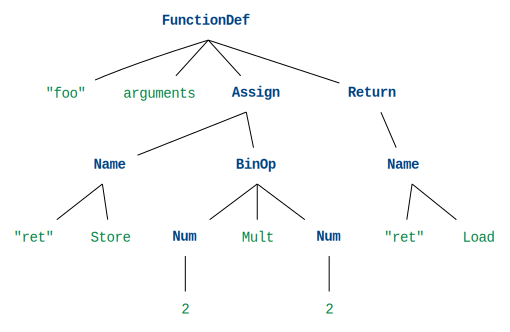

In [203]:
show_ast(tree)

You see that the function `foo()` has a `FunctionDef` node with four children: The function name (`"foo"`), its arguments (`arguments`; currently empty), followed by the statements that make the function body – `Assign` for the assignment, `Return` for the `return` statement.

We obtain and manipulate the AST through the Python modules `ast` and `astor`. The original Python `ast` reference is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

To instrument the above code, we need to insert a new statement as a child to `FunctionDef` node.

In [204]:
from ast import NodeTransformer, FunctionDef, fix_missing_locations

In [205]:
from types import FunctionType

Here's the code we want to inject:

In [206]:
subtree_to_be_injected = ast.parse("print('entering function')")

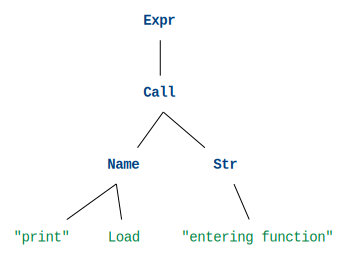

In [207]:
show_ast(subtree_to_be_injected)

The root of an `ast.parse()` tree actually is a `Module` node; we go directly to its child, which is the `Expr` node we want to inject.

In [208]:
subtree_to_be_injected = subtree_to_be_injected.body[0]

To inject the code, we use the `NodeTransformer` class as described in the Python `ast` documentation. We vist all function definitions (`FunctionDef`) and replace them with a new function definition in which the `body` gets an additional child – namely our subtree to be injected.

In [209]:
class InjectPass(NodeTransformer):
    def visit_FunctionDef(self, node):
        return FunctionDef(
            name=node.name,
            args=node.args,
            body=[subtree_to_be_injected] + node.body,
            decorator_list=node.decorator_list,
            returns=node.returns
        )

In [210]:
new_tree = fix_missing_locations(InjectPass().visit(tree))

This is what our new tree looks like:

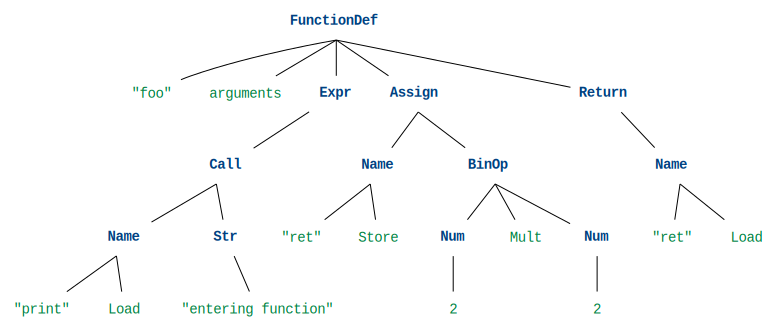

In [211]:
show_ast(new_tree)

This is what the tree looks like when converted back to source code:

In [212]:
new_source = astor.to_source(new_tree)
print_content(new_source, '.py')

def foo():
    print('entering function')
    ret = 2 * 2
    return ret


We can now compile the new source into a function:

In [213]:
exec(new_source)

... and happily invoke our instrumented function.

In [214]:
foo()

entering function


4

Your task is to implement a function `insert_tracer_ast(function, breakpoints)` that works like `insert_tracer()`, above, except that it uses this AST-based mechanism to inject debugging code into the given function.